In [1]:
from __future__ import print_function

import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import apache_beam as beam
import tensorflow_transform as tft

/usr/lib/python2.7/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/jupyter/.local/lib/python2.7/site-packages/scipy/optimize/_trlib/__init__.py:1: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._trlib import TRLIBQuadraticSubproblem
/home/jupyter/.local/lib/python2.7/site-packages/scipy/optimize/_numdiff.py:10: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._group_columns import group_dense, group_sparse
/home/jupyter/.local/lib/python2.7/site-packages/scipy/optimize/_minimize.py:37: ImportWarning: Not importing directory '/home/jupyter/.local/lib/python2.7/site-packages/scipy/optimize/lbfgsb': missing __init__.py
  from .lbfgsb import

In [2]:
df = pd.DataFrame.from_csv("atl_june.csv")

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.


In [3]:
df.describe()

,FL_YEAR,FL_MONTH,FL_DOM,FL_DOW,FL_NUM,ORIGIN_AIRPORT_SEQ_ID,DEST_AIRPORT_SEQ_ID,CRS_DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_DELAY,CANCELLED,CANCELLATION_CODE,DIVERTED,DISTANCE
count,403358.000000,403358.0,403358.000000,403358.000000,403358.000000,4.033580e+05,4.033580e+05,403358.000000,403358.000000,403358.000000,403358.000000,403358.000000,403358.000000,403358.000000,403358.000000,403358.0,0.0,403358.0,403358.000000
mean,2011.395998,6.0,15.575033,3.958536,2324.654210,1.039704e+06,1.278804e+06,1460.046948,15.029393,20.590726,1487.350684,1514.163475,6.049626,1552.945956,11.898465,0.0,NaN,0.0,643.922352
std,3.438737,0.0,8.637871,1.968028,1826.668615,9.995802e-01,1.519290e+05,463.110599,39.325740,11.310037,498.089658,538.377473,4.550384,499.354124,42.376085,0.0,NaN,0.0,471.523150
min,2006.000000,6.0,1.000000,1.000000,1.000000,1.039703e+06,1.013501e+06,500.000000,-54.000000,0.000000,1.000000,1.000000,0.000000,0.000000,-61.000000,0.0,NaN,0.0,79.000000
25%,2008.000000,6.0,8.000000,2.000000,873.000000,1.039703e+06,1.129802e+06,1035.000000,-3.000000,14.000000,1051.000000,1128.000000,4.000000,1150.000000,-10.000000,0.0,NaN,0.0,356.000000
50%,2011.000000,6.0,16.000000,4.000000,1711.000000,1.039703e+06,1.294502e+06,1453.000000,0.000000,18.000000,1510.000000,1535.000000,5.000000,1557.000000,-1.000000,0.0,NaN,0.0,547.000000
75%,2014.000000,6.0,23.000000,6.000000,4332.000000,1.039705e+06,1.410001e+06,1856.000000,15.000000,24.000000,1925.000000,1948.000000,7.000000,1958.000000,16.000000,0.0,NaN,0.0,743.000000
max,2017.000000,6.0,30.000000,7.000000,7425.000000,1.039705e+06,1.591902e+06,2350.000000,1427.000000,226.000000,2400.000000,2400.000000,230.000000,2359.000000,1444.000000,0.0,NaN,0.0,4502.000000


In [4]:
df300 = df[df['ARR_DELAY'] < 300]

In [5]:
df.columns

Index([u'FL_YEAR', u'FL_MONTH', u'FL_DOM', u'FL_DOW', u'UNIQUE_CARRIER',
       u'FL_NUM', u'ORIGIN_AIRPORT_SEQ_ID', u'DEST_AIRPORT_SEQ_ID', u'ORIGIN',
       u'DEST', u'CRS_DEP_TIME', u'DEP_DELAY', u'TAXI_OUT', u'WHEELS_OFF',
       u'WHEELS_ON', u'TAXI_IN', u'CRS_ARR_TIME', u'ARR_DELAY', u'CANCELLED',
       u'CANCELLATION_CODE', u'DIVERTED', u'DISTANCE'],
      dtype='object')

In [6]:
frac = df300.sample(frac=0.01)

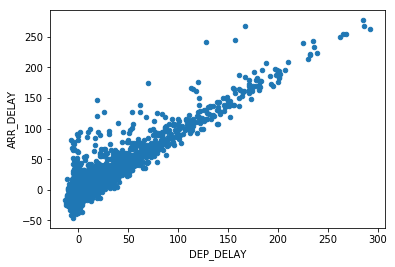

In [7]:
frac.plot.scatter(x='DEP_DELAY', y='ARR_DELAY');

We're not surprised to see a strong correlation between departure delay and arrival delay. However, many flights are able to catch up. 

In [23]:
counts = df.groupby(['DEST']).count()

In [24]:
counts = counts[counts['FL_YEAR'] >= 1000]

In [25]:
dest1000s = list(counts.to_dict()['FL_YEAR'].keys())

#### All destinations with 1000 or more arrivals from Atlanta in June

In [26]:
np.array(dest1000s)

array(['JFK', 'GSP', 'FNT', 'ROC', 'MIA', 'BOS', 'OAJ', 'LIT', 'AGS',
       'GSO', 'SAN', 'MYR', 'DCA', 'HSV', 'BWI', 'PIT', 'RIC', 'SAT',
       'CHA', 'IAH', 'JAX', 'IAD', 'JAN', 'CHS', 'EYW', 'GPT', 'BNA',
       'PHL', 'SNA', 'PHF', 'SFO', 'PHX', 'LAX', 'LAS', 'CRW', 'CMH',
       'AEX', 'FLL', 'DEN', 'DTW', 'EVV', 'SYR', 'ROA', 'BMI', 'VLD',
       'BUF', 'TRI', 'GRR', 'SHV', 'BDL', 'CSG', 'LEX', 'DSM', 'EWR',
       'PBI', 'BTR', 'MGM', 'AVL', 'OKC', 'IND', 'MOB', 'TYS', 'ILM',
       'XNA', 'LFT', 'PVD', 'SEA', 'ECP', 'SLC', 'MDW', 'MDT', 'RDU',
       'PDX', 'CLE', 'DFW', 'SJU', 'AUS', 'SRQ', 'CLT', 'TLH', 'OMA',
       'MEM', 'ALB', 'SAV', 'TUL', 'ORF', 'ORD', 'MKE', 'GNV', 'MSY',
       'MSP', 'CAK', 'CVG', 'CAE', 'FAY', 'TPA', 'DAB', 'DAL', 'DAY',
       'SGF', 'MLB', 'DHN', 'STL', 'MLI', 'ABQ', 'HOU', 'HPN', 'MLU',
       'ABY', 'ICT', 'MCO', 'RSW', 'BHM', 'VPS', 'MCI', 'PNS', 'LGA',
       'SDF', 'PWM'], dtype='|S3')

Creating a mask for those destinations and filter the original data frame. This will take about two minutes, so be patient.

In [27]:
f = [ df.iloc[k].to_dict()['DEST'] in dest1000s for k in range(len(df))]
df1k=df[f]

Now take only the ones that have less than 5 hours delay. We consider the others outliers

In [28]:
df1k_300 = df1k[df1k['ARR_DELAY'] < 300]
df1k_300.to_csv('atl_june_1k_300.csv')

#### Load the dataframe from the pre-processed file

In [29]:
df1k_300 = pd.DataFrame.from_csv('atl_june_1k_300.csv')

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.


In [30]:
len(df1k_300)

379672

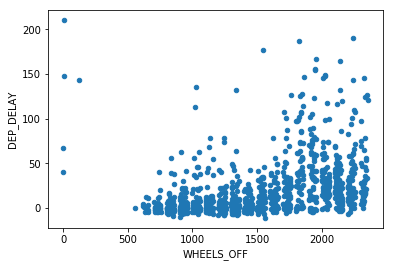

In [31]:
one_day = df1k_300['2007-06-15']
one_day.plot.scatter(x='WHEELS_OFF', y='DEP_DELAY')

In [32]:
len(one_day)

1112

In [251]:
hrs = np.array(range(24))*100
res = {}
for hr in hrs:
    after = one_day[one_day['CRS_DEP_TIME'] >= hr]
    between = after[after['CRS_DEP_TIME'] <= hr+59]
    m = between['DEP_DELAY'].mean()
    res[hr] = 0 if np.isnan(m) else m
res

{0: 0,
 100: 0,
 200: 0,
 300: 0,
 400: 0,
 500: 0.0,
 600: 6.083333333333333,
 700: 6.089285714285714,
 800: 4.404761904761905,
 900: 3.878787878787879,
 1000: 8.46551724137931,
 1100: 8.26984126984127,
 1200: 8.98611111111111,
 1300: 5.063492063492063,
 1400: 12.643835616438356,
 1500: 18.5,
 1600: 37.8,
 1700: 39.72839506172839,
 1800: 38.732142857142854,
 1900: 35.666666666666664,
 2000: 36.75949367088607,
 2100: 30.40740740740741,
 2200: 26.547619047619047,
 2300: 16.1}

### Tensorflow data validation
Generating the statistics can take a couple of minutes. Be patient, ok?

In [1]:
import tensorflow_data_validation as tfdv

/usr/lib/python2.7/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/jupyter/.local/lib/python2.7/site-packages/scipy/spatial/__init__.py:96: ImportWarning: Not importing directory '/home/jupyter/.local/lib/python2.7/site-packages/scipy/spatial/qhull': missing __init__.py
  from .qhull import *
/home/jupyter/.local/lib/python2.7/site-packages/scipy/optimize/_minimize.py:37: ImportWarning: Not importing directory '/home/jupyter/.local/lib/python2.7/site-packages/scipy/optimize/lbfgsb': missing __init__.py
  from .lbfgsb import _minimize_lbfgsb


In [2]:
stats = tfdv.generate_statistics_from_csv('atl_june.csv')

In [3]:
tfdv.visualize_statistics(stats)

In [4]:
schema = tfdv.infer_schema(stats)

In [5]:
tfdv.display_schema(schema)

,Type,Presence,Valency,Domain
Feature name,,,,
'FL_MONTH',INT,required,,-
'FL_NUM',INT,required,,-
'CRS_ARR_TIME',INT,required,,-
'CRS_DEP_TIME',INT,required,,-
'ARR_DELAY',FLOAT,required,,-
'TAXI_IN',INT,required,,-
'DIVERTED',INT,required,,-
'WHEELS_ON',INT,required,,-
'WHEELS_OFF',INT,required,,-


,Values
Domain,
'ORIGIN','ATL'
'UNIQUE_CARRIER',"'9E', 'AA', 'AS', 'B6', 'CO', 'DL', 'EV', 'F9', 'FL', 'MQ', 'NK', 'NW', 'OH (1)', 'OO', 'UA', 'US', 'WN', 'XE', 'YV'"
